In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

from importlib import resources

In [2]:
import pandas as pd
import numpy as np


def gen_data(
    g1=2000,
    g2=2010,
    g3=0,
    panel=(1990, 2020),
    te1=2,
    te2=2,
    te3=2,
    te_m1=0,
    te_m2=0,
    te_m3=0,
    n=1500,
):
    """
    Generate panel dataset with treatment effects

    Parameters:
    -----------
    g1, g2, g3 : int
        Treatment dates for groups 1, 2, 3. Use 0 for no treatment
    panel : tuple
        Start and end years for panel
    te1, te2, te3 : float
        Treatment effects for groups 1, 2, 3
    te_m1, te_m2, te_m3 : float
        Treatment effect slopes per year
    n : int
        Number of individuals in sample
    """

    # Create initial dataframe
    df = pd.DataFrame(
        {
            "unit": range(1, n + 1),
            "state": np.random.choice(range(1, 41), size=n),
            "group_val": np.random.uniform(0, 1, size=n),
        }
    )

    # Add unit fixed effects
    df["unit_fe"] = np.random.normal(df["state"] / 5, 1, size=n)

    # Assign groups
    df["group"] = pd.cut(
        df["group_val"],
        bins=[0, 0.33, 0.66, 1],
        labels=["Group 1", "Group 2", "Group 3"],
    )

    # Assign treatment dates
    df["g"] = df["group"].map({"Group 1": g1, "Group 2": g2, "Group 3": g3})

    # Create panel structure
    years = range(panel[0], panel[1] + 1)
    df = df.loc[df.index.repeat(len(years))].reset_index(drop=True)
    df["year"] = np.tile(years, n)

    # Sort by unit and year
    df = df.sort_values(["unit", "year"])

    # Add year fixed effects
    year_fe = pd.Series(np.random.normal(0, 0.2, size=len(years)), index=years)
    df["year_fe"] = df["year"].map(year_fe)

    # Add treatment variables
    df["treat"] = (df["year"] >= df["g"]) & (df["g"].between(panel[0], panel[1]))
    df["rel_year"] = df["year"] - df["g"]
    df.loc[df["g"] == 0, "rel_year"] = np.inf

    # Bin relative years
    df["rel_year_binned"] = df["rel_year"].clip(-6, 6)

    # Add random error
    df["error"] = np.random.normal(0, 1, size=len(df))

    # Calculate treatment effects
    df["te"] = (
        (df["group"] == "Group 1") * te1 * (df["year"] >= g1)
        + (df["group"] == "Group 2") * te2 * (df["year"] >= g2)
        + (df["group"] == "Group 3") * te3 * (df["year"] >= g3)
    )

    df["te_dynamic"] = (
        (df["group"] == "Group 1") * (df["year"] >= g1) * te_m1 * (df["year"] - g1)
        + (df["group"] == "Group 2") * (df["year"] >= g2) * te_m2 * (df["year"] - g2)
        + (df["group"] == "Group 3") * (df["year"] >= g3) * te_m3 * (df["year"] - g3)
    )

    # Calculate dependent variable
    df["dep_var"] = (
        df["unit_fe"] + df["year_fe"] + df["te"] + df["te_dynamic"] + df["error"]
    )

    return df


# Example usage:
# Homogeneous treatment effect
df_hom = gen_data(
    g1=2000, g2=2010, g3=0, te1=2, te2=2, te3=0, te_m1=0, te_m2=0, te_m3=0
)

# # Heterogeneous treatment effect
# df_het = gen_data(g1=2000, g2=2010, g3=0,
#                   te1=2, te2=1, te3=0,
#                   te_m1=0.05, te_m2=0.15, te_m3=0)

TypeError: Cannot compare a Categorical for op __le__ with type <class 'numpy.ndarray'>.
If you want to compare values, use 'np.asarray(cat) <op> other'.

In [3]:
def saturated_event_study(
    df,
    outcome="outcome",
    treatment="treated",
    time_id="time",
    unit_id="unit",
    ax=None,
    ret_mod=False,
):
    if ax is None:
        f, ax = plt.subplots()

    df = df.merge(
        df.assign(first_treated_period=df[time_id] * df[treatment])
        .groupby(unit_id)["first_treated_period"]
        .apply(lambda x: x[x > 0].min()),
        on=unit_id,
    )
    df["rel_time"] = df[time_id] - df["first_treated_period"]
    df["first_treated_period"] = (
        df["first_treated_period"].replace(np.nan, 0).astype("int")
    )
    df["rel_time"] = df["rel_time"].replace(np.nan, np.inf)
    cohort_dummies = pd.get_dummies(
        df.first_treated_period, drop_first=True, prefix="cohort_dummy"
    )
    df_int = pd.concat([df, cohort_dummies], axis=1)
    ff = f"""
                {outcome} ~
                {'+'.join([f"i(rel_time, {x}, ref = -1.0)" for x in df_int.filter(like = "cohort_dummy", axis = 1).columns])}
                | {unit_id} + {time_id}
                """
    m3 = pf.feols(ff, df_int, vcov={"CRV1": unit_id})
    if ret_mod:
        return m3
    res = m3.tidy()
    # create a dict with cohort specific effect curves
    res_dict = {}
    for c in cohort_dummies.columns:
        res_cohort = res.filter(like=c, axis=0)
        event_time = (
            res_cohort.index.str.extract(r"\[T\.(-?\d+\.\d+)\]")
            .astype(float)
            .values.flatten()
        )
        res_dict[c] = {"est": res_cohort, "time": event_time}

    i = 0
    cmp = plt.get_cmap("Set1")
    for k, v in res_dict.items():
        ax.plot(v["time"], v["est"]["Estimate"], marker=".", label=k, color=cmp(i))
        ax.fill_between(
            v["time"], v["est"]["2.5%"], v["est"]["97.5%"], alpha=0.2, color=cmp(i)
        )
        i += 1
    ax.axvline(-1, color="black", linestyle="--")
    ax.axhline(0, color="black", linestyle=":")
    return ax

## example

In [4]:
df_multi_cohort = pd.read_csv(
    resources.files("pyfixest.did.data").joinpath("df_het.csv")
)
df_multi_cohort.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

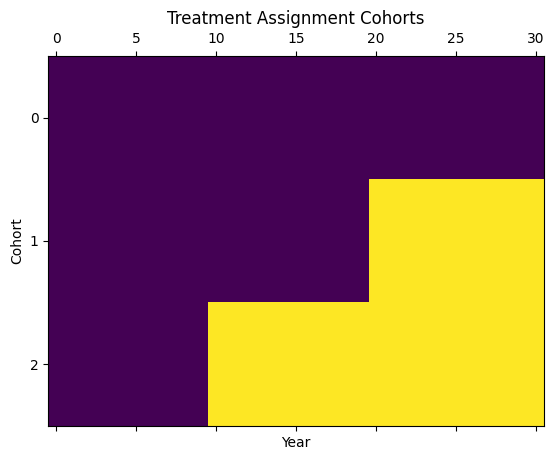

In [5]:
pf.panelview(
    df_multi_cohort,
    unit="unit",
    time="year",
    treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

### event study

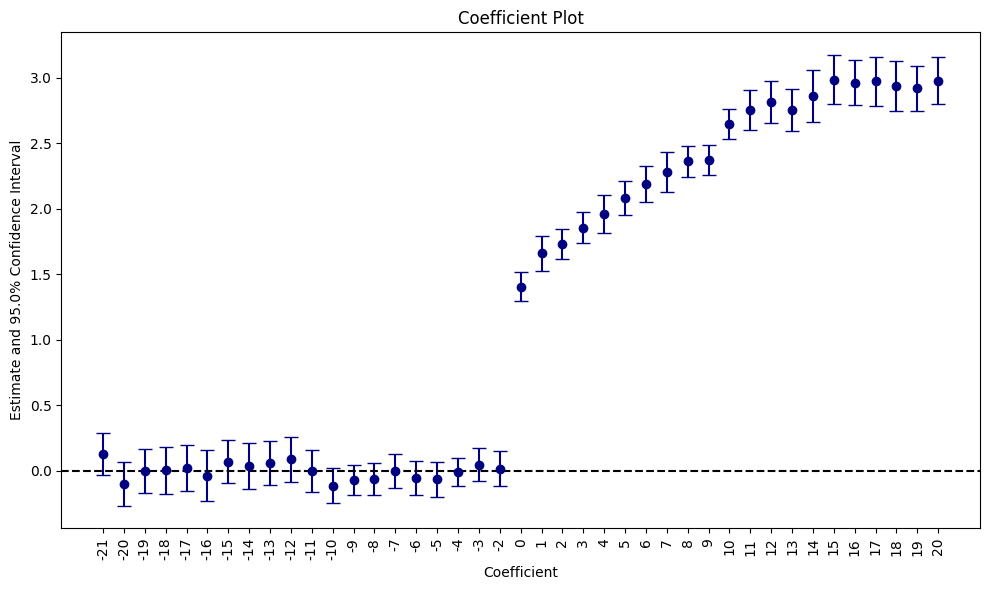

In [6]:
fit_evstud = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    df_multi_cohort,
    vcov={"CRV1": "state"},
)
indices = np.r_[-21:21:1]
labs = dict(zip(fit_evstud._coefnames, indices[indices != -1].astype(str).tolist()))
fit_evstud.iplot(
    plot_backend="matplotlib",
    coord_flip=False,
    labels=labs,
    rotate_xticks=90,
)

### saturated

/home/alal/Desktop/forks/pyfixest/pyfixest/estimation/feols_.py:2540: UserWarning: 
            The following variables are collinear: ['C(rel_time, contr.treatment(base=-1.0))[T.-20.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-19.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-18.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-17.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-16.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-15.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-14.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-13.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-12.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.-11.0]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.inf]:cohort_dummy_2000', 'C(rel_time, contr.treatment(base=-1.0))[T.11.0]:cohort_dummy_2010', 'C(rel_time, contr.treatmen

<Axes: >

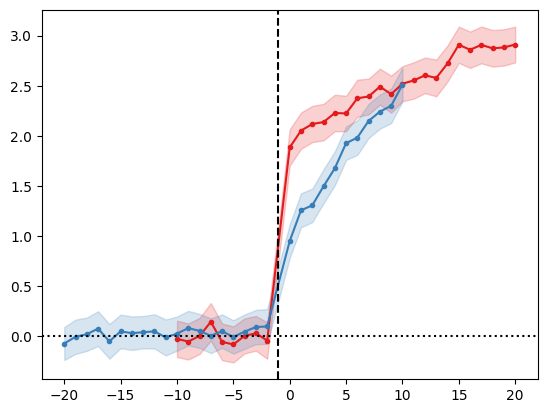

In [7]:
saturated_event_study(
    df_multi_cohort,
    outcome="dep_var",
    treatment="treat",
    unit_id="unit",
    time_id="year",
)

- Heterogeneity by cohort or time 